In [1]:
using Distributions
using Random
using StatsPlots
default(fmt=:png, titlefontsize=10, plot_titlefontsize=12, tickfontsize=6)

ecdf_(A, x) = count(≤(x), A) / length(A)

function tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    (x̄ - ȳ - Δμ) / √(sx²/m + sy²/n)
end

function tvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function degree_of_freedom_welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function degree_of_freedom_welch(x, y)
    m, sx² = length(x), var(x)
    n, sy² = length(y), var(y)
    degree_of_freedom_welch(m, sx², n, sy²)
end

function pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ=0)
    t = tvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    2ccdf(TDist(ν), abs(t))
end

function pvalue_welch(x, y; Δμ=0)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    pvalue_welch(m, x̄, sx², n, ȳ, sy²; Δμ)
end

function confint_welch(m, x̄, sx², n, ȳ, sy²; α=0.05)
    ν = degree_of_freedom_welch(m, sx², n, sy²)
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m + sy²/n)
    [x̄-ȳ-c*SEhat, x̄-ȳ+c*SEhat]
end

function confint_welch(x, y; α=0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    n, ȳ, sy² = length(y), mean(y), var(y)
    confint_welch(m, x̄, sx², n, ȳ, sy²; α)
end

confint_welch (generic function with 2 methods)

In [2]:
function sim(;
        distx = Gamma(2), 
        disty = Gamma(2), 
        m = 20,
        n = 40,
        transformations = (identity, log),
        L = 10^6,
    )
    pval = zeros(L)
    nth = Threads.nthreads()
    Xtmp = [zeros(m) for _ in 1:nth]
    Ytmp = [zeros(n) for _ in 1:nth]
    XX = [zeros(m) for _ in 1:nth]
    YY = [zeros(n) for _ in 1:nth]
    Threads.@threads :static for i in 1:L
        tid = Threads.threadid()
        X = rand!(distx, Xtmp[tid])
        Y = rand!(disty, Ytmp[tid])
        fX, fY = XX[tid], YY[tid]
        pval[i] = 1.0
        for f in transformations
            @. fX = f(X)
            @. fY = f(Y)
            pval_new = pvalue_welch(fX, fY)
            pval[i] = min(pval[i], pval_new)
        end
    end
    pval
end

distname(dist) = replace(string(dist), r"{[^}]*}"=>"")
distname(dist::Gamma) = "Gamma$(params(dist))"
distname(dist::InverseGamma) = "InverseGamma$(params(dist))"

function plot_sim2x2(;
        distx = Gamma(4),
        disty = distx,
        mns = ((50, 50), (40, 60), (30, 70), (20, 80)),
        transformations = (identity, log),
        distlim = :auto,
        L = 10^6,
    )    
    PP = []
    for (m, n) in mns
        pval = sim(; distx, disty, m, n, transformations, L)
        P = plot(α -> ecdf_(pval, α), 0, 0.1; label="")
        plot!(identity; label="", c=:gray, ls=:dot)
        plot!(xtick=0:0.01:1, ytick=0:0.01:1, xrotation=90)
        plot!(xguide="α", yguide="probability of P-value ≤ α")
        title!("m=$m, n=$n")
        push!(PP, P)
    end
    
    plot()
    if distx == disty
        plot!(distx; label="")
        distxname = distname(distx)
        title!("distx = disty = $(distxname)")
    else
        plot!(distx; label="distx")
        plot!(disty; label="disty", ls=:dash)
    end
    plot!(xlim=distlim)
    plot!(size=(400, 200)) |> display
    
    plot(PP...; size=(600, 700))
    plot!(plot_title="transformations: $(transformations)")
end

function plot_sims(;
        distx = Gamma(4),
        disty = distx,
        α = 0.05,
        ms = 50:10:90,
        ns = 50:-10:10,
        transformations1 = (identity,),
        transformations2 = (log,),
        transformations3 = (identity, log),
        distlim = :auto,
        ytick=0:0.005:1,
        L = 10^6,
    )
    
    plot()
    if distx == disty
        plot!(distx; label="")
        distxname = distname(distx)
        title!("distx = disty = $(distxname)")
    else
        plot!(distx; label="distx")
        plot!(disty; label="disty", ls=:dash)
    end
    plot!(xlim=distlim)
    plot!(size=(400, 200)) |> display
    
    N = length(ms)
    alphaerr1 = zeros(N)
    alphaerr2 = zeros(N)
    alphaerr3 = zeros(N)
    for (i, (m, n)) in enumerate(zip(ms, ns))
        pval1 = sim(; distx, disty, m, n, transformations=transformations1, L)
        alphaerr1[i] = ecdf_(pval1, α)
        pval2 = sim(; distx, disty, m, n, transformations=transformations2, L)
        alphaerr2[i] = ecdf_(pval2, α)
        pval3 = sim(; distx, disty, m, n, transformations=transformations3, L)
        alphaerr3[i] = ecdf_(pval3, α)
    end
    plot(1:N, alphaerr1; label=string(transformations1), marker=:o)
    plot!(1:N, alphaerr2; label=string(transformations2), marker=:square, ls=:dash)
    plot!(1:N, alphaerr3; label=string(transformations3), marker=:star, ls=:dashdot)
    plot!(tickfontsize=8, legendfontsize=12, titlefontsize=12)
    plot!(; xtick=(1:N, string.((m, n) for (m, n) in zip(ms, ns))), ytick)
    plot!(xguide="sample sizes (m, n)")
    title!("Probability of P-value ≤ $(100α)%")
end

plot_sims (generic function with 1 method)

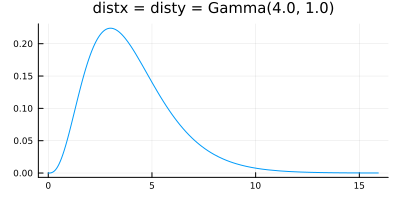

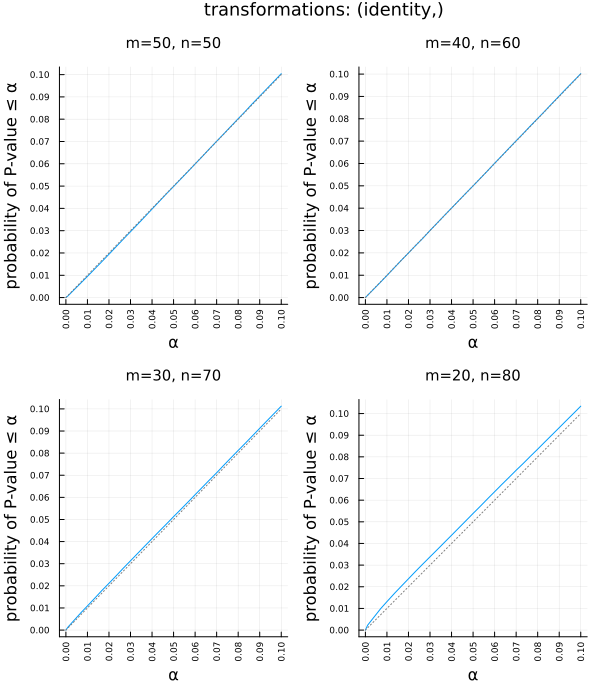

In [3]:
plot_sim2x2(; distx=Gamma(4), transformations=(identity,))

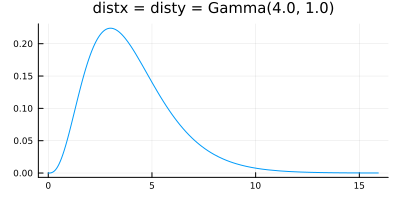

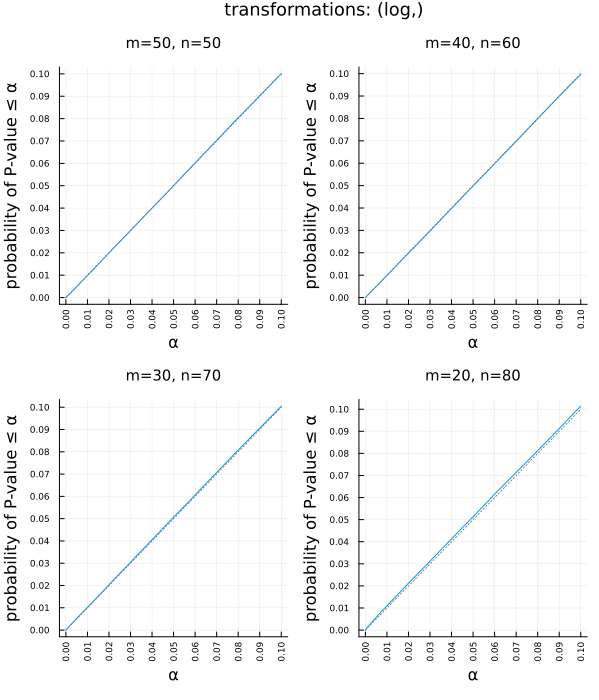

In [4]:
plot_sim2x2(; distx=Gamma(4), transformations=(log,))

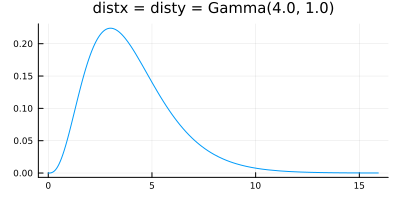

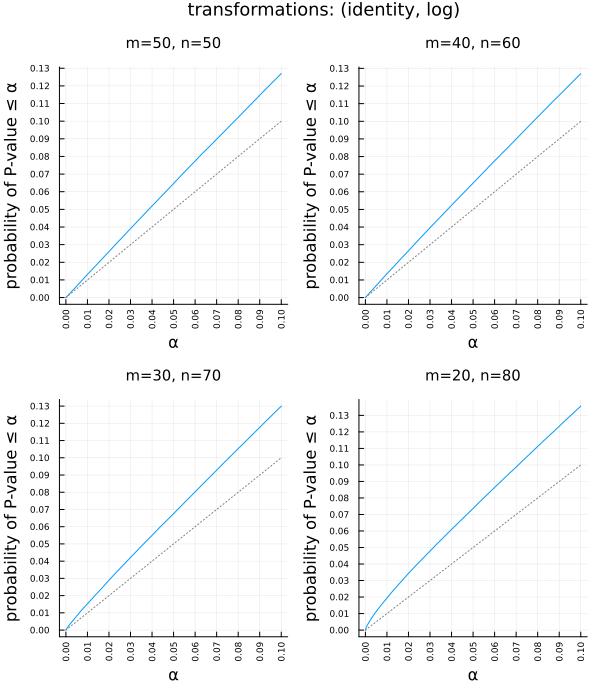

In [5]:
plot_sim2x2(; distx=Gamma(4), transformations=(identity, log,))

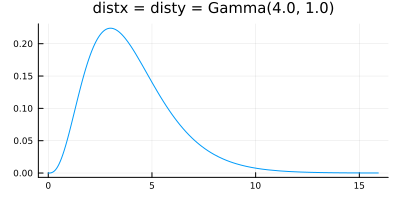

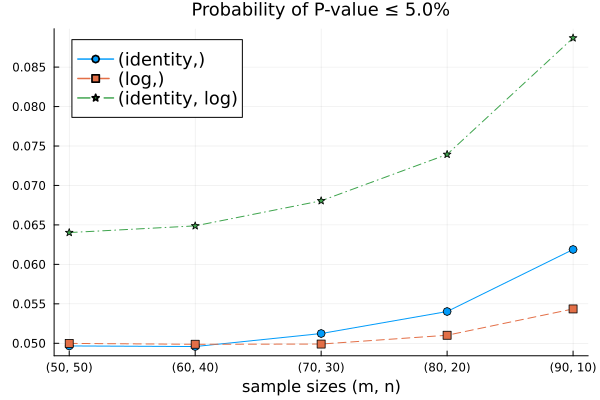

In [6]:
plot_sims(distx=Gamma(4), transformations2=(log,), transformations3=(identity, log))

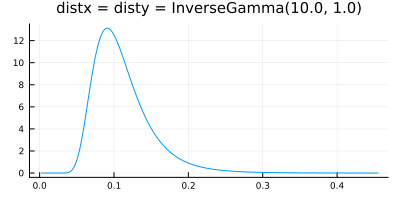

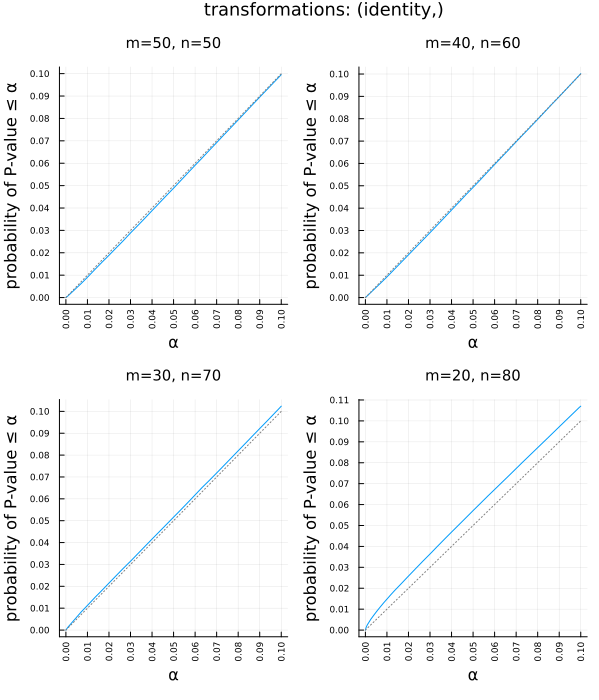

In [7]:
plot_sim2x2(; distx=InverseGamma(10), transformations=(identity,))

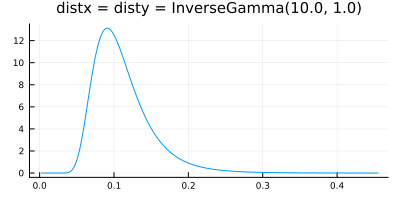

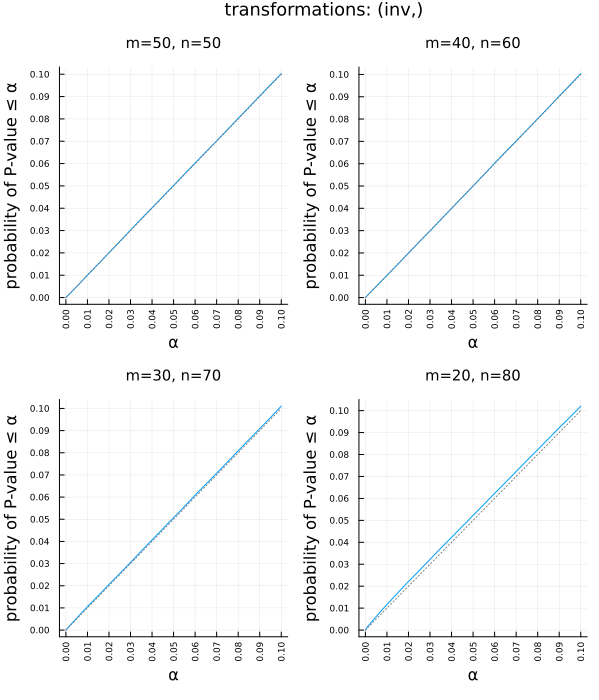

In [8]:
plot_sim2x2(; distx=InverseGamma(10), transformations=(inv,))

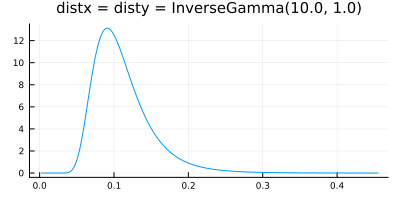

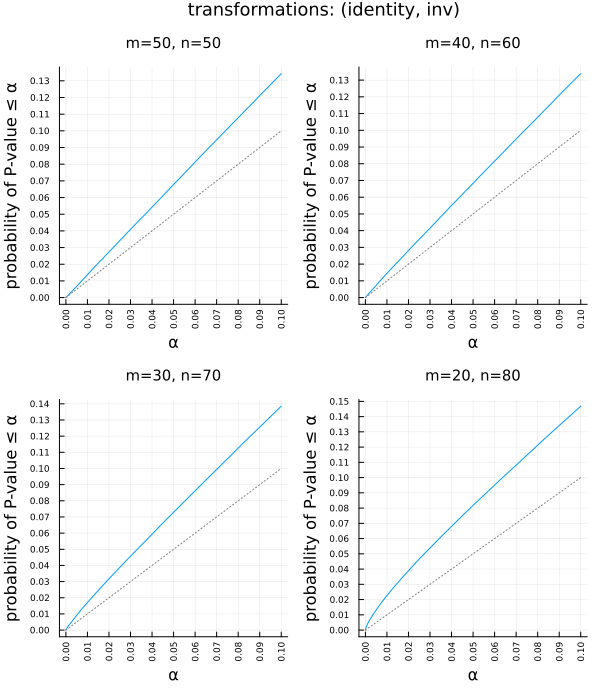

In [9]:
plot_sim2x2(; distx=InverseGamma(10), transformations=(identity, inv,))

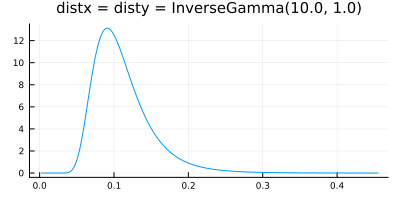

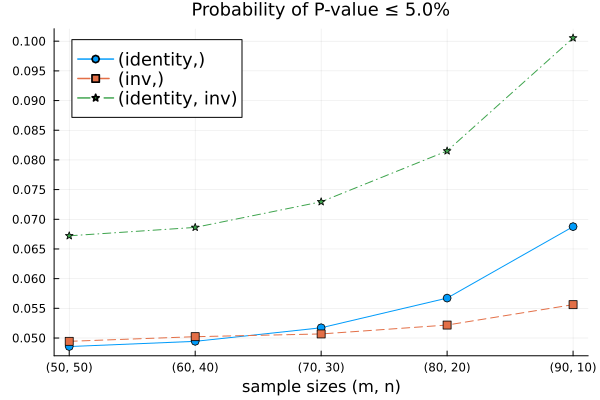

In [10]:
plot_sims(distx=InverseGamma(10), transformations2=(inv,), transformations3=(identity, inv))